In [2]:
import pandas as pd
from pathlib import Path
import xarray as xr
import numpy as np
import calendar
import os.path
from dateutil.relativedelta import relativedelta
import tensorflow as tf

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Input, Dense, Masking
from tensorflow.keras.models import Model
from tqdm.keras import TqdmCallback

import seaborn as sns
from matplotlib import pyplot as plt

2023-07-21 20:03:45.812580: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-21 20:03:45.862833: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-21 20:03:45.864049: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-21 20:03:46.619625: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
zarr_ds = xr.open_zarr(store='/home/jovyan/shared/data/INDIAN_OCEAN_025GRID_DAILY.zarr', consolidated=True)
zarr_ds

<xarray.Dataset>
Dimensions:          (time: 16071, lat: 177, lon: 241)
Coordinates:
  * lat              (lat) float32 32.0 31.75 31.5 31.25 ... -11.5 -11.75 -12.0
  * lon              (lon) float32 42.0 42.25 42.5 42.75 ... 101.5 101.8 102.0
  * time             (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2022-12-31
Data variables: (12/19)
    CHL              (time, lat, lon) float32 dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    CHL_uncertainty  (time, lat, lon) float32 dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    adt              (time, lat, lon) float32 dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    air_temp         (time, lat, lon) float32 dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    curr_dir         (time, lat, lon) float32 dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    curr_speed       (time, lat, lon) float32 dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    ...               ...
    ug_curr          (time, lat, lon) float32 dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    v_curr           (time, lat, lon) float32 dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    v_wind           (time, lat, lon) float32 dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    vg_curr          (time, lat, lon) float32 dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    wind_dir         (time, lat, lon) float32 dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
    wind_speed       (time, lat, lon) float32 dask.array<chunksize=(100, 177, 241), meta=np.ndarray>
Attributes: (12/17)
    creator_email:              minhphan@uw.edu
    creator_name:               Minh Phan
    creator_type:               person
    date_created:               2023-07-19
    geospatial_lat_max:         32.0
    geospatial_lat_min:         -12.0
    ...                         ...
    geospatial_lon_units:       degrees_east
    source:                     Earth & Space Research (ESR), Copernicus Clim...
    summary:                    Daily mean of 0.25 x 0.25 degrees gridded dat...
    time_coverage_end:          2022-12-31T23:59:59
    time_coverage_start:        1979-01-01T00:00:00
    title:                      Climate Data for Coastal Upwelling Machine Le...

In [4]:
zarr_new = zarr_ds.sel(lat=slice(35, -5), lon=slice(45,90))

In [5]:
def create_data_map(variable_name, start_date='2010-01-01', end_date='2022-12-31'):
    date_range = pd.date_range(start=start_date, end=end_date)

    zarr_dates = pd.to_datetime(zarr_new.time.values)

    # times we don't have labels
    skip_ranges = [
        pd.date_range(start='1983-04-01', end='1983-04-30'),
        pd.date_range(start='1988-02-01', end='1988-02-29'),  # February in a leap year
        pd.date_range(start='1992-09-01', end='1992-09-30'),
        pd.date_range(start='1997-02-01', end='1997-02-28'),
        pd.date_range(start='2001-11-01', end='2001-11-30'),
        pd.date_range(start='2006-04-01', end='2006-04-30'),
        pd.date_range(start='2011-02-01', end='2011-02-28'),
        pd.date_range(start='2015-06-01', end='2015-06-30'),
        pd.date_range(start='2020-02-01', end='2020-02-29')  # February in a leap year
    ]

    date_to_data_map = {}

    for date in date_range:
        if any(date in skip_range for skip_range in skip_ranges):
            continue
        if date in zarr_dates:
            data = getattr(zarr_new, variable_name).sel(time=str(date.date())).values
            if not np.all(np.isnan(data)):
                mean_val = np.nanmean(data)
                normalized_day_data = data - mean_val
                normalized_day_data = np.nan_to_num(normalized_day_data, nan=0.0)

                date_to_data_map[date] = normalized_day_data

    return date_to_data_map

In [6]:
data_map_speed = create_data_map('wind_speed')
data_map_dir = create_data_map('wind_dir')

In [7]:
def get_labels(start_date, end_date):
    # Convert input dates to datetime format
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)

    # List to store all group labels
    all_labels = pd.Series(dtype=int)

    # Initialize current date to start_date
    curr_date = start_date

    while curr_date <= end_date:
        year = curr_date.year
        month = curr_date.month

        file_name = f"/home/jovyan/shared/jiarui-notebooks/shared/SST_Diff_0/{year}{month:02d}_sst_diff.nc"
        if not Path(file_name).exists():
            print(f"File {file_name} does not exist, skipping...")
            curr_date += relativedelta(months=1)
            continue
        print(f"Processing file {file_name}...")

        # Open the dataset and convert it to a pandas DataFrame
        temp = xr.open_dataset(file_name)
        temp_df = temp.to_dataframe()

        # Convert the 'time' column to date only format
        temp_df.index = pd.to_datetime(temp_df.index).date

        # Reset index to create 'time' column
        temp_df = temp_df.reset_index()

        # Create a new column 'entry_id' which enumerates each entry within each date
        temp_df['entry_id'] = temp_df.groupby('time').cumcount()

        # Filter dataframe for rows where 'entry_id' is 22 and 23, and create a copy
        filtered_df = temp_df[temp_df['entry_id'].isin([22,23])].copy()

        # Create a label column - set to 1 if SST_Diff < threshold, else set to 0
        threshold = -1
        filtered_df.loc[:, 'label'] = np.where(filtered_df['SST_Diff'] < threshold, 1, 0)

        # Group by 'time' and check if all 'label' in a group is 1, if so, set group_label to 1, else 0
        group_labels = filtered_df.groupby('time')['label'].apply(lambda x: 1 if x.sum() == 2 else 0)

        # Append the group_labels to all_labels
        all_labels = pd.concat([all_labels, group_labels])

        # Move to the next month
        curr_date += relativedelta(months=1)

    print(all_labels.shape)
    return all_labels

# Call the function with your specific start and end date
labels = get_labels('2010-01-01', '2022-12-31')

Processing file /home/jovyan/shared/jiarui-notebooks/shared/SST_Diff_0/201001_sst_diff.nc...
Processing file /home/jovyan/shared/jiarui-notebooks/shared/SST_Diff_0/201002_sst_diff.nc...
Processing file /home/jovyan/shared/jiarui-notebooks/shared/SST_Diff_0/201003_sst_diff.nc...
Processing file /home/jovyan/shared/jiarui-notebooks/shared/SST_Diff_0/201004_sst_diff.nc...
Processing file /home/jovyan/shared/jiarui-notebooks/shared/SST_Diff_0/201005_sst_diff.nc...
Processing file /home/jovyan/shared/jiarui-notebooks/shared/SST_Diff_0/201006_sst_diff.nc...
Processing file /home/jovyan/shared/jiarui-notebooks/shared/SST_Diff_0/201007_sst_diff.nc...
Processing file /home/jovyan/shared/jiarui-notebooks/shared/SST_Diff_0/201008_sst_diff.nc...
Processing file /home/jovyan/shared/jiarui-notebooks/shared/SST_Diff_0/201009_sst_diff.nc...
Processing file /home/jovyan/shared/jiarui-notebooks/shared/SST_Diff_0/201010_sst_diff.nc...
Processing file /home/jovyan/shared/jiarui-notebooks/shared/SST_Diff_0

In [8]:
common_dates = set(data_map_speed.keys()) & set(data_map_dir.keys())
data_map_speed = {date: data_map_speed[date] for date in common_dates}
data_map_dir = {date: data_map_dir[date] for date in common_dates}
filtered_labels = labels[labels.index.isin(common_dates)]

In [9]:
combined_data_map = {}
for date in common_dates:
    speed_data = data_map_speed[date]
    dir_data = data_map_dir[date]
    
    combined_data = np.zeros((*speed_data.shape, 2))
    
    combined_data[:, :, 0] = speed_data
    combined_data[:, :, 1] = dir_data
    
    combined_data_map[date] = combined_data

In [21]:
X = np.array(list(combined_data_map.values()))
y = filtered_labels.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
sample_data = next(iter(combined_data_map.values()))
input_shape = (sample_data.shape[0], sample_data.shape[1], sample_data.shape[2])

In [23]:
# Define the model
base_model = EfficientNetB0(include_top=False, weights=None, input_shape=input_shape)

In [24]:
# Add a global spatial average pooling layer
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
# Add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# And a logistic layer
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

tqdm_callback = TqdmCallback(verbose=1)

# Train the model
model.fit(X_train, y_train, epochs=50, verbose=0, callbacks=[tqdm_callback])

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Accuracy: {accuracy}")

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

27/27 [==============================] - 7s 215ms/step - loss: 1.2421 - accuracy: 0.8561
Accuracy: 0.8561320900917053


In [30]:
data = []  # List to store each row of the DataFrame

for date, day_data in combined_data_map.items():
    actual_val = filtered_labels[date]
    
    day_data_batched = np.expand_dims(day_data, axis=0)
    prediction = model.predict(day_data_batched, verbose=0)
    
    # Append the data for the current date to the list
    data.append({'time': date, 'actual_val': actual_val, 'predicted_val': prediction[0][0]})

# Create a DataFrame from the data list
df = pd.DataFrame(data)

# Check the DataFrame
print(df)

           time  actual_val  predicted_val
0    2010-12-26           0   2.576217e-03
1    2017-08-30           1   8.279561e-05
2    2011-10-16           0   6.667132e-08
3    2014-02-09           0   1.974092e-06
4    2019-08-09           0   8.408787e-06
...         ...         ...            ...
4231 2018-07-17           1   1.099355e-05
4232 2018-08-06           1   3.147328e-04
4233 2014-02-26           0   2.778158e-04
4234 2013-06-27           0   1.360921e-05
4235 2013-09-10           1   1.598298e-07

[4236 rows x 3 columns]


In [33]:
print(len(df[(df['actual_val'] == 0) & (df['predicted_val'] > 0.5)]))
print(len(df[(df['actual_val'] == 0)]))
print(len(df[(df['actual_val'] == 1) & (df['predicted_val'] > 0.5)]))
print(len(df[(df['actual_val'] == 1)]))

398
3725
48
511


/tmp/ipykernel_113/2030461022.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(group0, bins=20, kde=False, norm_hist=True, label='Actual_val 0')
/tmp/ipykernel_113/2030461022.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(group1, bins=20, kde=False, norm_hist=True, label='Actual_val 1'

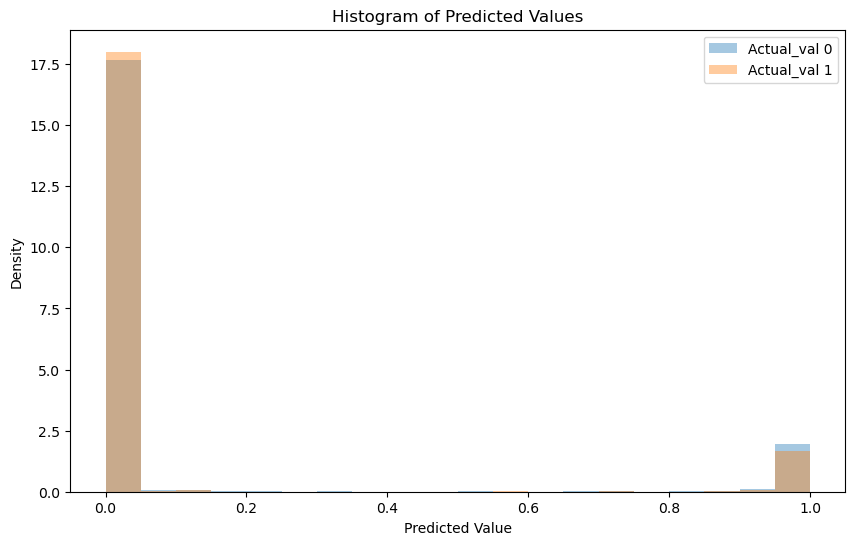

In [34]:
# Convert 'predicted_val' to float
df['predicted_val'] = df['predicted_val'].apply(lambda x: float(x[0]) if isinstance(x, (list, np.ndarray)) else float(x))

# Separate the data into two groups based on 'actual_val'
group0 = df[df['actual_val'] == 0]['predicted_val']
group1 = df[df['actual_val'] == 1]['predicted_val']

# Create the histogram plot
plt.figure(figsize=(10, 6))
sns.distplot(group0, bins=20, kde=False, norm_hist=True, label='Actual_val 0')
sns.distplot(group1, bins=20, kde=False, norm_hist=True, label='Actual_val 1')

# Set the labels and title
plt.xlabel('Predicted Value')
plt.ylabel('Density')
plt.title('Histogram of Predicted Values')
plt.legend()

# Show the plot
plt.show()